In [1]:
import numpy as np
from scipy import linalg
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.collections
import matplotlib.patches
import pg_fitter_tools as fit
import sk_geo_tools as geo
import cv2
from collections import Counter

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [57]:
#%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [4]:
focal_length = np.array([1742, 1744])
principle_point = np.array([2000, 1500])
radial_distortion = np.array([-0.251, 0.0689])
tangential_distortion = np.array([0, 0])
camera_matrix = fit.build_camera_matrix(focal_length, principle_point)
distortion = fit.build_distortion_array(radial_distortion, tangential_distortion)

In [118]:
camera_radial_position = 400
camera_halfz_position = 300
camera_positions = np.array([
    [0, 0, -camera_radial_position],
    [0, 0, camera_radial_position],
    [-camera_radial_position, 0, 0],
    [camera_radial_position, 0, 0],
    [0, -camera_halfz_position, 0],
    [0, camera_halfz_position, 0]])
camera_directions = np.array([
    [0, 0, 1],
    [0, 0, -1],
    [1, 0, 0],
    [-1, 0, 0],
    [0, 1, 0],
    [0, -1, 0]])
camera_rolls = np.array([0, 0, 0, 0, 0, np.pi/2.])
camera_rotations, camera_translations = fit.camera_poses(camera_positions, camera_directions, camera_rolls)

In [6]:
pmt_locations = fit.read_3d_feature_locations("parameters/IWCD_PMT_locations.txt", delimiter=" ")
#mpmt_locations = {k: v for k, v in pmt_locations.items() if int(k)%19==0}
mpmt_locations = fit.read_3d_feature_locations("parameters/IWCD_centrePMT_locations.txt", delimiter=" ")
mpmt_orientations = {k: np.array((0,-1,0)) if v[1]>290 else np.array((0,1,0)) if v[1]<-290 else np.array((-v[0],0,-v[2]))/np.sqrt(v[0]**2+v[2]**2) for k, v in mpmt_locations.items()}

In [7]:
def get_led_positions(led_count, mpmt_locations):
    led_ring_radius = 24.
    led_positions = {}
    for k, v in mpmt_locations.items():
        for i in range(led_count):
            if abs(v[1]) > 290:
                led_positions[k+'-'+str(i)] = v+led_ring_radius*np.array([np.sin(i*2*np.pi/led_count),0,np.cos(i*2*np.pi/led_count)])
            else:
                phi = np.arctan2(v[2], v[0])
                led_positions[k+'-'+str(i)] = v+led_ring_radius*np.array([np.sin(i*2*np.pi/led_count)*np.sin(phi), np.cos(i*2*np.pi/led_count), -np.sin(i*2*np.pi/led_count)*np.cos(phi)])
    return led_positions

In [8]:
def get_image_feature_locations(feature_positions, camera_matrix, distortion, camera_rotations, camera_translations):
    image_feature_locations = {
        i : {list(feature_positions.keys())[f]:v for f, v in enumerate(cv2.projectPoints(np.array(list(feature_positions.values())), r, t, camera_matrix, distortion)[0].reshape((-1,2)))
             if v[0] > 0 and v[0] < 4000 and v[1] > 0 and v[1] < 3000}
        for i, (r, t) in enumerate(zip(camera_rotations, camera_translations))}
    feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
    print("Feature in image counts:", Counter(feature_counts.values()))
    return image_feature_locations

In [9]:
def get_smeared_feature_locations(image_feature_locations, pixel_error):
    smeared_feature_locations = {}
    for k, i in image_feature_locations.items():
        smeared_feature_locations[k] = {}
        for j, f in i.items():
            smeared = np.random.normal(f, pixel_error)
            if(smeared[0] > 0 and smeared[0] < 4000 and smeared[1] > 0 and smeared[1] < 3000):
                smeared_feature_locations[k][j] = smeared
    smeared_feature_counts = Counter([f for i in smeared_feature_locations.values() for f in i.keys()])
    print("Smeared feature in image counts:", Counter(smeared_feature_counts.values()))
    return smeared_feature_locations

In [10]:
def setup_led_simulation(feature_positions, image_feature_locations, focal_length, principle_point, radial_distortion, seed_error=1):
    seed_feature_positions = {}
    for i, f in feature_positions.items():
        seed_feature_positions[i] = np.random.normal(f, seed_error)
    fitter = fit.PhotogrammetryFitter(image_feature_locations, seed_feature_positions, focal_length, principle_point, radial_distortion)
    return fitter

In [11]:
def plot_images(image_feature_locations):
    for i in image_feature_locations.values():
        fig, ax = plt.subplots(figsize=(12,9))
        coords = np.rint(np.stack(list(i.values())))
        ax.scatter(coords[:,0], -coords[:,1], marker='s', s=0.2)
        ax.set_xlim((0, 4000))
        ax.set_ylim((-3000, 0))
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        fig.tight_layout()

In [12]:
def run_led_fit(fitter, led_positions):
    reco_cam_rotations, reco_cam_translations, reprojected_points = fitter.estimate_camera_poses()
    reco_cam_rotations, reco_cam_translations, reco_locations = fitter.bundle_adjustment(reco_cam_rotations, reco_cam_translations)
    
    reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(led_positions, reco_locations)
    print("mean reconstruction error:", linalg.norm(reco_errors, axis=1).mean())
    print("max reconstruction error:", linalg.norm(reco_errors, axis=1).max())

    reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(reco_cam_rotations, reco_cam_translations)
    cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
    cam_positions_translated = reco_cam_positions - translation
    cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

    reco_led_positions = reco_positions_dict(reco_transformed, fitter.feature_index)
    position_errors = linalg.norm(reco_errors, axis=1)

    return reco_led_positions, position_errors

In [13]:
def reco_positions_dict(reco_positions, feature_index):
    return {f: reco_positions[i] for f, i in feature_index.items()}

In [14]:
def get_mpmt_centre_errors(reco_led_positions, mpmt_positions, led_count):
    reco_mpmt_positions = {k: np.mean([reco_led_positions[k + "-" + str(b)] for b in range(led_count)], axis=0)
                           for k in mpmt_positions.keys()}
    errors = np.array([linalg.norm(reco_mpmt_positions[k] - mpmt_positions[k]) for k in mpmt_positions.keys()])
    return errors

In [15]:
def get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_coun):
    reco_orientations = {}
    for k in mpmt_orientations.keys():
        c, n = geo.fit_plane(np.array([reco_led_positions[k + "-" + str(b)] for b in range(led_count)]))
        # flip normal if it is directed away from tank centre
        if np.dot(n,c) > 0:
            n = -n
        reco_orientations[k] = n
    errors = np.array([np.degrees(np.arccos(np.dot(reco_orientations[k], mpmt_orientations[k]))) for k in mpmt_orientations.keys()])
    return errors

In [16]:
def make_fig(title, xlabel, figsize=(8,6)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    fig.tight_layout()
    return fig, ax

# Simulation with 3 LEDs

Feature in image counts: Counter({4: 896, 3: 612, 5: 100})


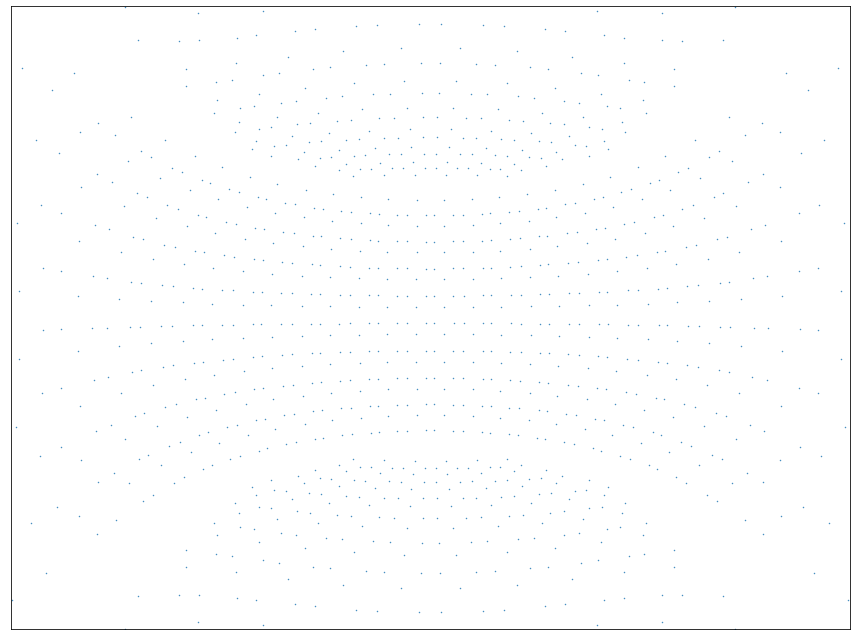

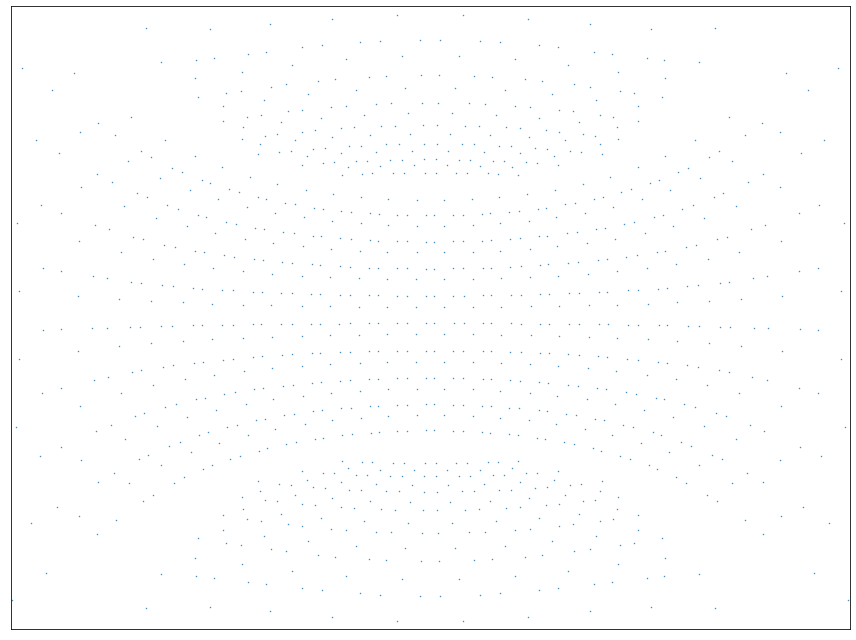

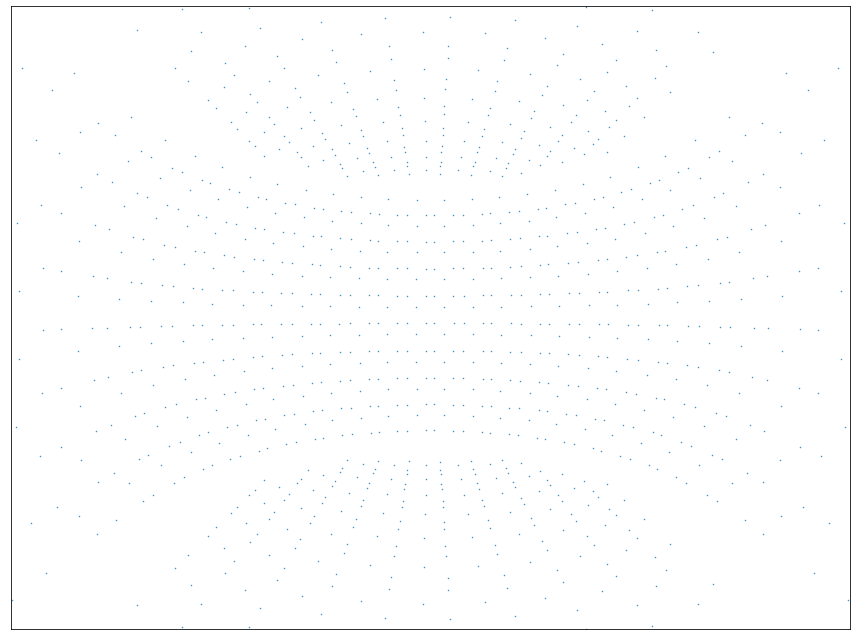

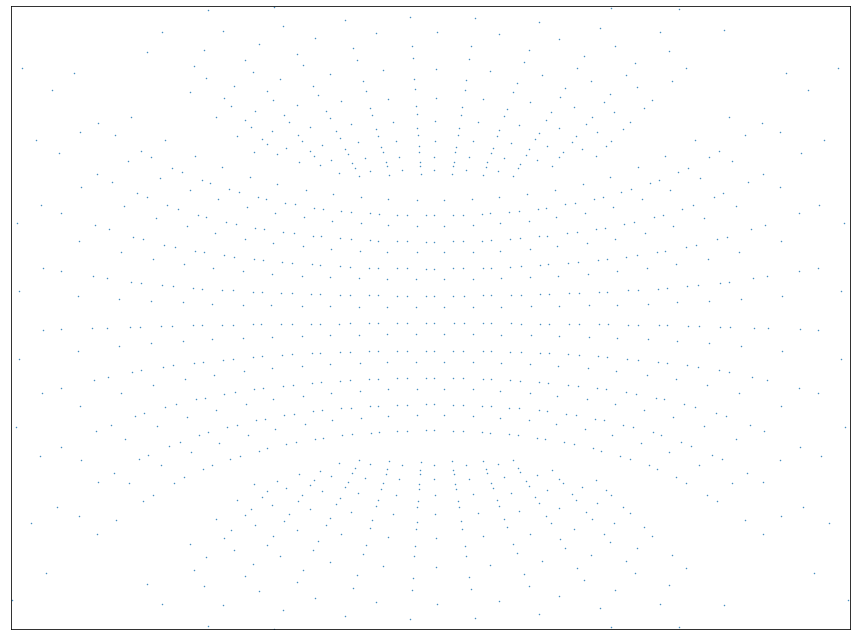

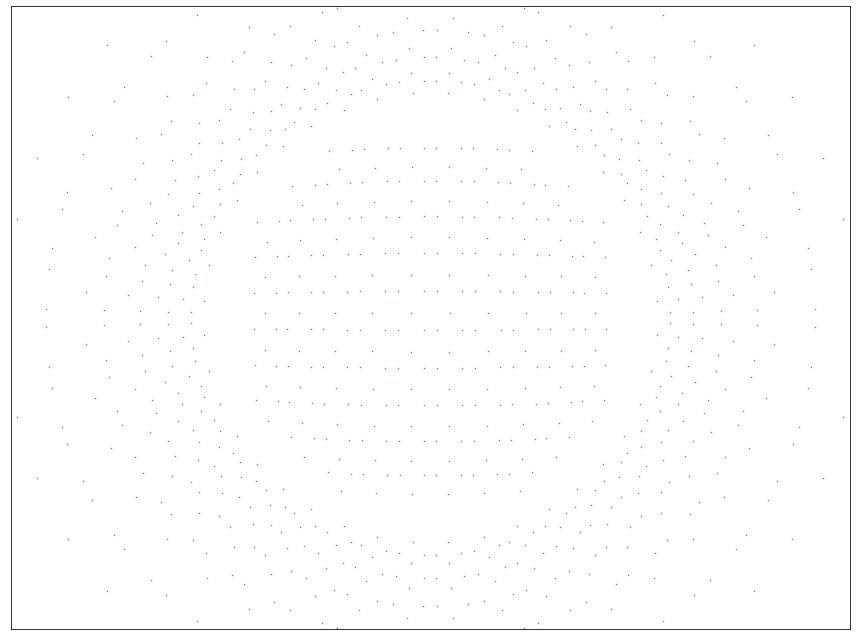

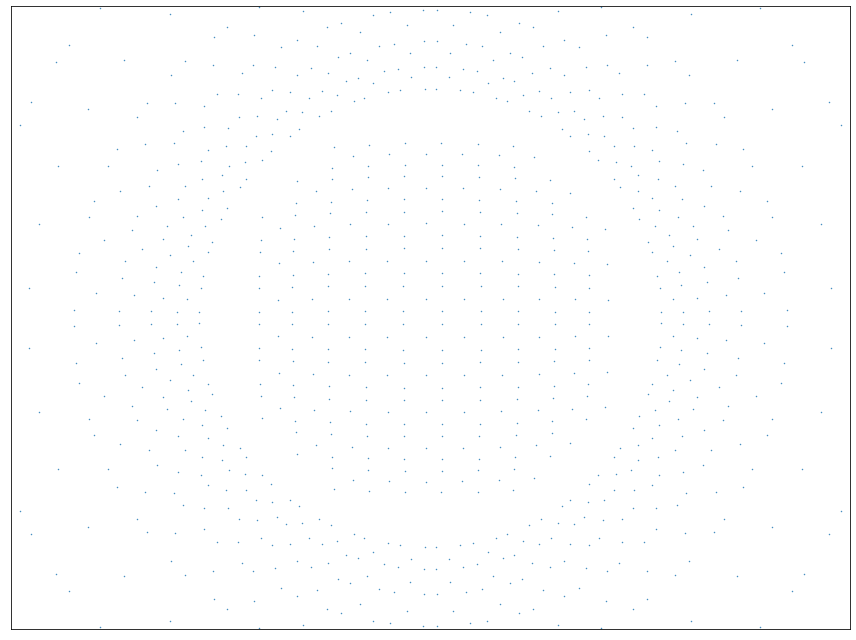

In [124]:
led_count = 3
led_positions = get_led_positions(led_count, mpmt_locations)
simulator = fit.PhotogrammetrySimulator(led_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)
image_feature_locations = simulator.get_image_feature_locations(area_restrict = [[0, 4000], [0, 3000]], min_feature_count = 2)
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
print("Feature in image counts:", Counter(feature_counts.values()))
simulator.show_images(image_feature_locations, area=[[0,4000],[0,3000]])

=== Gaussian errors on feature image locations: 0.5 ===
6 images with total of  1608 features
image 0 reprojection errors:    average: 4.340338392085088    max: 37.951581636020975
image 1 reprojection errors:    average: 4.140477384045164    max: 29.3934604543355
image 2 reprojection errors:    average: 4.1183311622938525    max: 35.971259644900115
image 3 reprojection errors:    average: 4.2747557473399125    max: 33.67020774310861
image 4 reprojection errors:    average: 4.595305429609767    max: 19.52079870083589
image 5 reprojection errors:    average: 4.6213884313954345    max: 31.545279193604603
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.5181e+04                                    3.29e+05    
       1              2         5.8413e+02      8.46e+04       6.85e+01       4.44e+03    
       2              3         5.7286e+02      1.13e+01       6.27e-01       1.83e+02    
       3              4    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1764e+05                                    2.52e+05    
       1              2         1.9948e+04      9.77e+04       7.41e+01       1.01e+04    
       2              3         1.9576e+04      3.73e+02       1.08e+01       4.29e+03    
       3              4         1.9501e+04      7.47e+01       1.63e+00       3.38e+02    
       4              5         1.9492e+04      8.61e+00       3.64e-01       1.81e+02    
       5              6         1.9487e+04      5.16e+00       2.56e-01       7.39e+01    
       6              7         1.9485e+04      2.54e+00       1.24e-01       7.74e+01    
       7              8         1.9484e+04      9.78e-01       3.03e-02       1.54e+01    
       8              9         1.9483e+04      7.67e-01       5.48e-02       4.24e+01    
       9             10         1.9482e+04      7.67e-01       2.69e-02       2.18e+01    

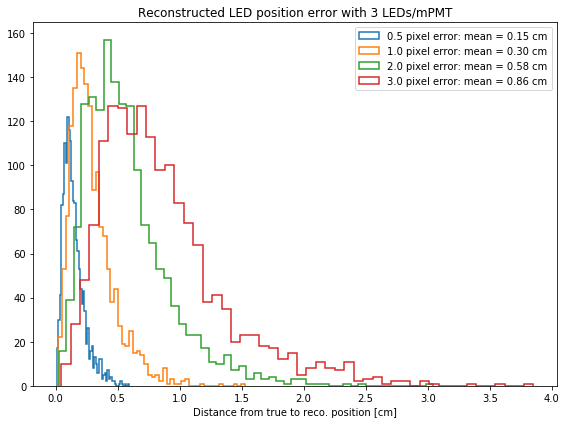

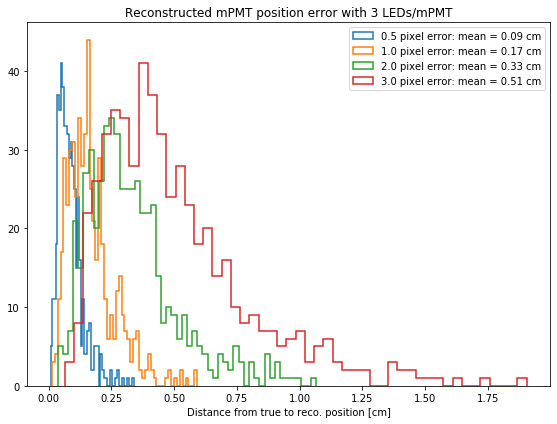

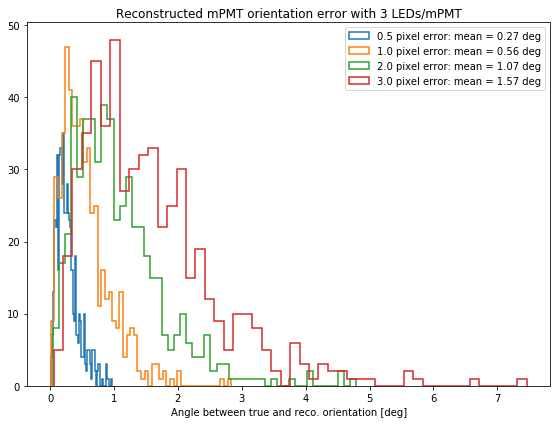

In [125]:
fig_led_pos, ax_led_pos = make_fig("Reconstructed LED position error with {} LEDs/mPMT".format(led_count), "Distance from true to reco. position [cm]")
fig_mpmt_pos, ax_mpmt_pos = make_fig("Reconstructed mPMT position error with {} LEDs/mPMT".format(led_count), "Distance from true to reco. position [cm]")
fig_mpmt_ang, ax_mpmt_ang = make_fig("Reconstructed mPMT orientation error with {} LEDs/mPMT".format(led_count), "Angle between true and reco. orientation [deg]")
for pixel_error in [0.5, 1.0, 2.0, 3.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=[[0, 4000], [0, 3000]], min_feature_count=2, pixel_error=pixel_error)
    led_positions2 = {k: v for k, v in led_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_led_simulation(led_positions2, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_led_positions, position_errors = run_led_fit(fitter, led_positions)
    centre_errors = get_mpmt_centre_errors(reco_led_positions, mpmt_locations, led_count)
    orientation_errors = get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_count)
    ax_led_pos.hist(position_errors, bins=50, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors.mean()))
    ax_mpmt_pos.hist(centre_errors, bins=50, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors.mean()))
    ax_mpmt_ang.hist(orientation_errors, bins=50, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors.mean()))
ax_led_pos.legend(loc='upper right')
ax_mpmt_pos.legend(loc='upper right')
ax_mpmt_ang.legend(loc='upper right')

# Simulation with 4 LEDs

Feature in image counts: Counter({4: 1184, 3: 816, 5: 144})
=== Gaussian errors on feature image locations: 0.5 ===
6 images with total of  2144 features
image 0 reprojection errors:    average: 4.527915670719363    max: 250.91374530588496
image 1 reprojection errors:    average: 4.441463254942345    max: 165.85287880830532
image 2 reprojection errors:    average: 4.9239823058407195    max: 464.4913992607864
image 3 reprojection errors:    average: 4.340275257159244    max: 145.8971665562064
image 4 reprojection errors:    average: 4.613710696633232    max: 68.90214329585345
image 5 reprojection errors:    average: 4.7623814064190215    max: 48.28418448290888
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.3674e+05                                    1.40e+07    
       1              2         1.2976e+04      3.24e+05       6.98e+01       4.70e+06    
       2              3         1.1584e+03      1.18e+04   

      22             23         1.2619e+04      3.73e+00       4.01e-02       2.06e+02    
      23             24         1.2612e+04      6.76e+00       1.39e-01       8.66e+02    
      24             25         1.2607e+04      5.29e+00       3.30e-02       1.07e+02    
      25             26         1.2563e+04      4.40e+01       1.15e+00       2.57e+03    
      26             27         1.2526e+04      3.71e+01       6.25e-02       3.05e+01    
      27             28         1.2467e+04      5.88e+01       1.75e+00       1.40e+03    
      28             29         1.2415e+04      5.15e+01       7.89e-02       9.49e+01    
      29             30         1.2406e+04      9.17e+00       3.02e-01       6.17e+02    
      30             31         1.2397e+04      9.31e+00       5.62e-02       9.38e+01    
      31             32         1.2396e+04      1.31e+00       3.69e-02       1.75e+02    
      32             33         1.2394e+04      1.28e+00       1.75e-02       8.03e+01    

      68             69         2.7726e+04      2.04e+00       2.18e-02       1.97e+02    
      69             70         2.7724e+04      1.89e+00       2.41e-02       1.85e+02    
      70             71         2.7722e+04      1.63e+00       1.70e-02       1.60e+02    
`xtol` termination condition is satisfied.
Function evaluations 71, initial cost 5.1750e+05, final cost 2.7722e+04, first-order optimality 1.60e+02.
mean reprojection error: 2.3112700406372353
max reprojection error: 10.024176245562968
mean reconstruction error: 0.78617331475951
max reconstruction error: 2.849534823499326


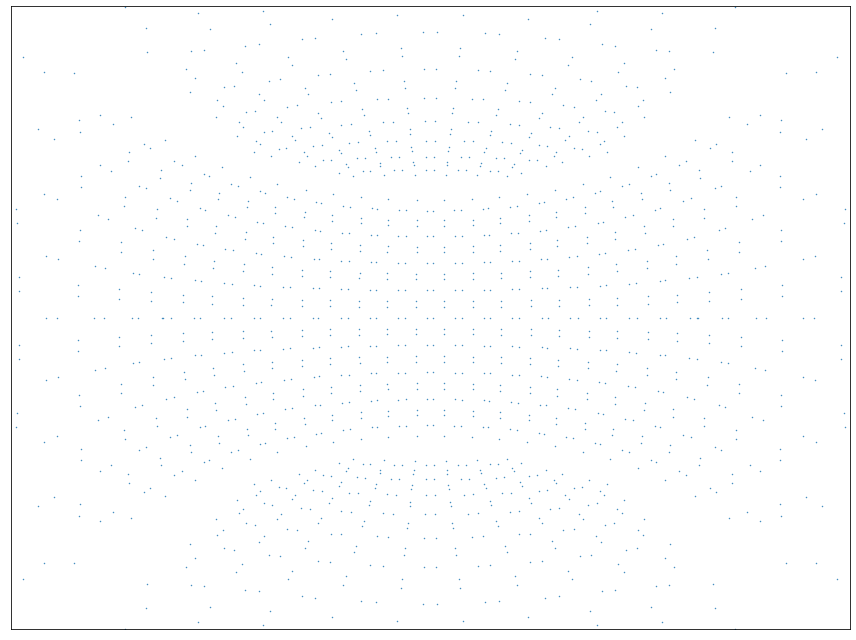

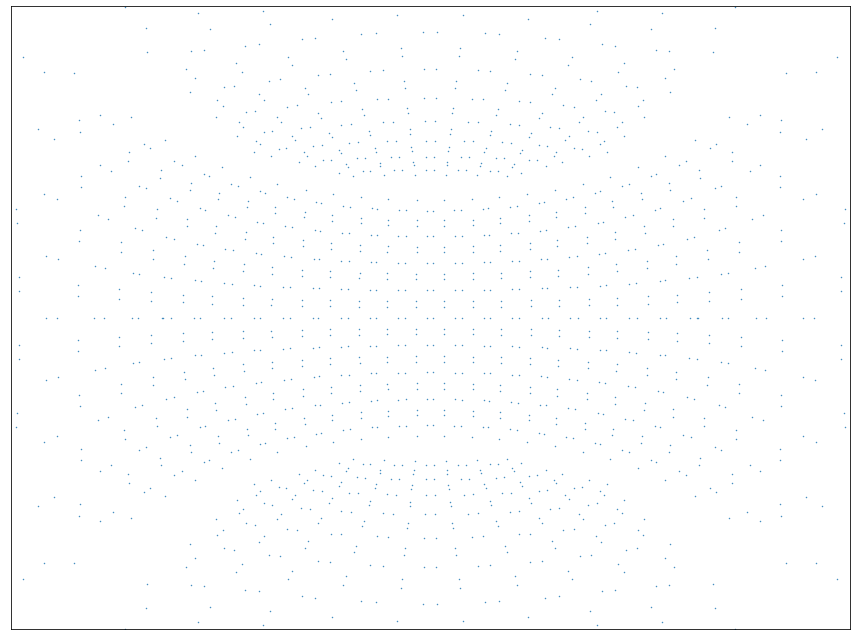

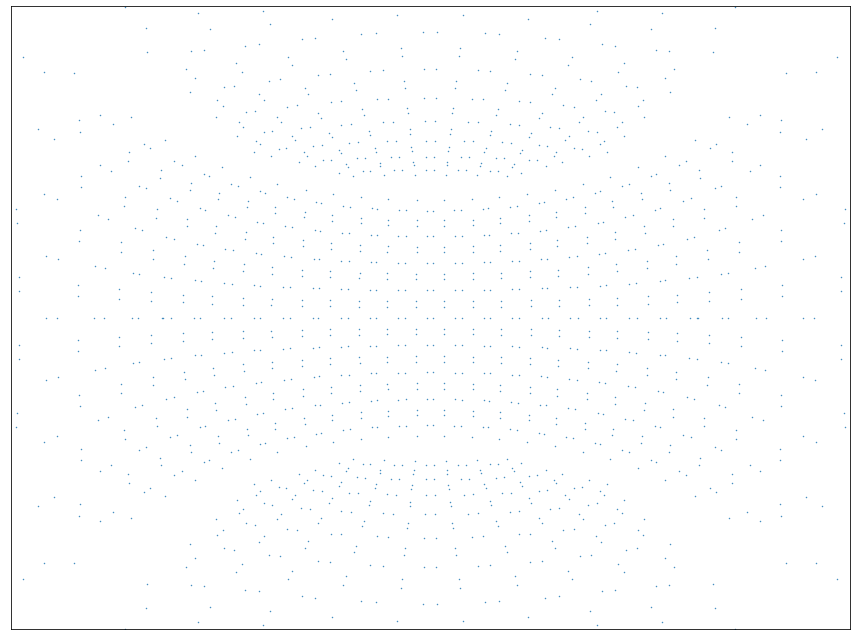

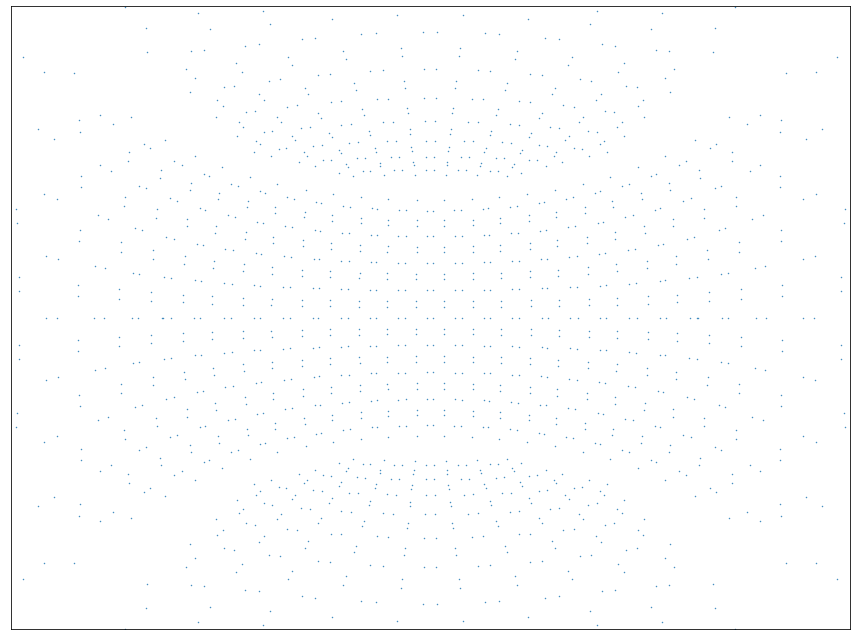

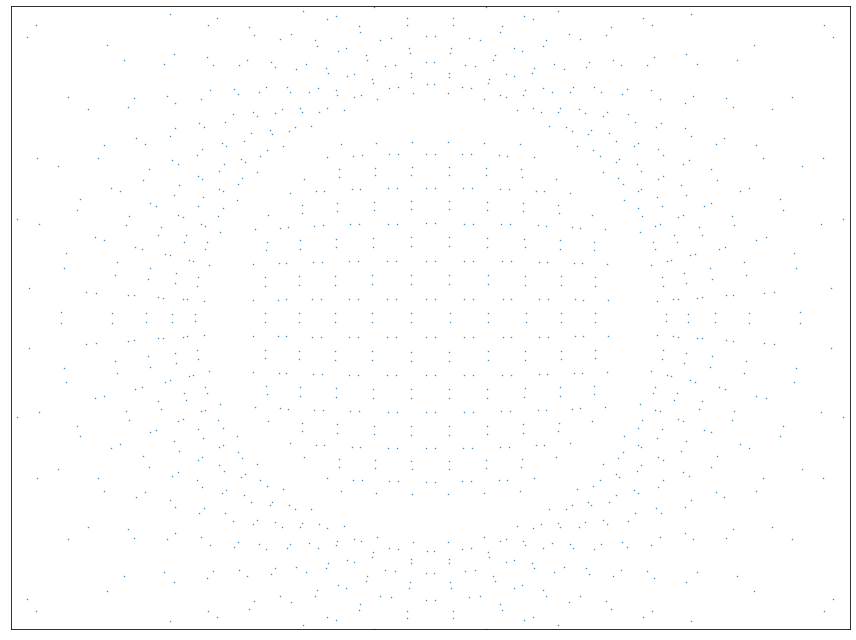

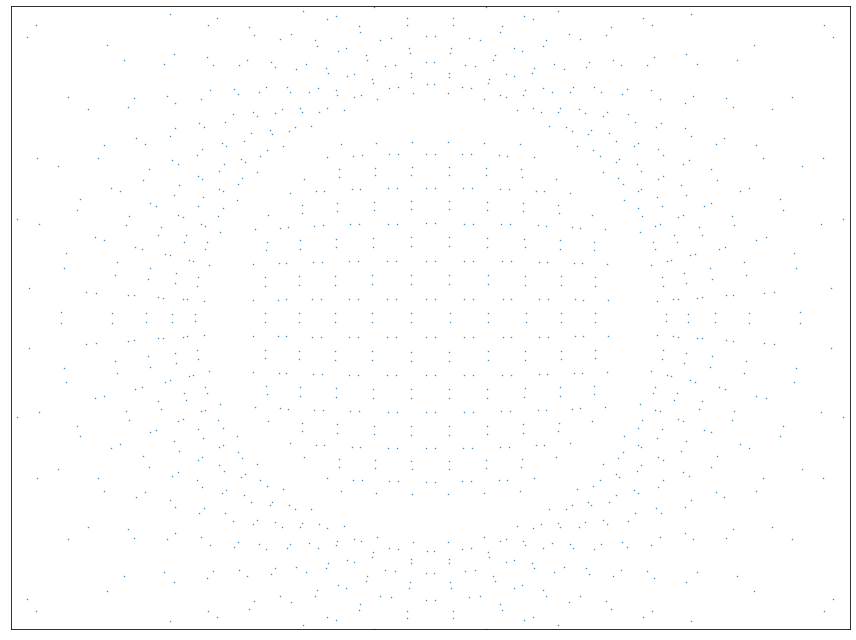

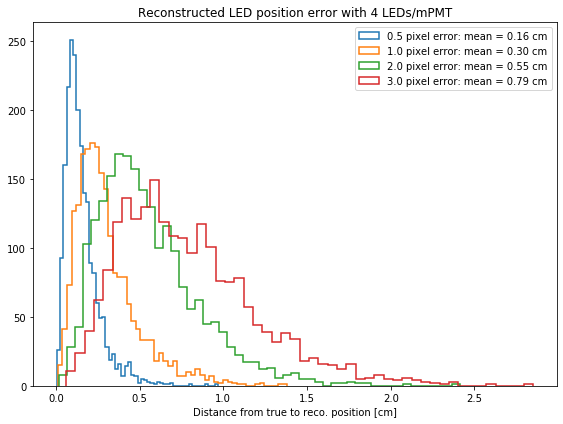

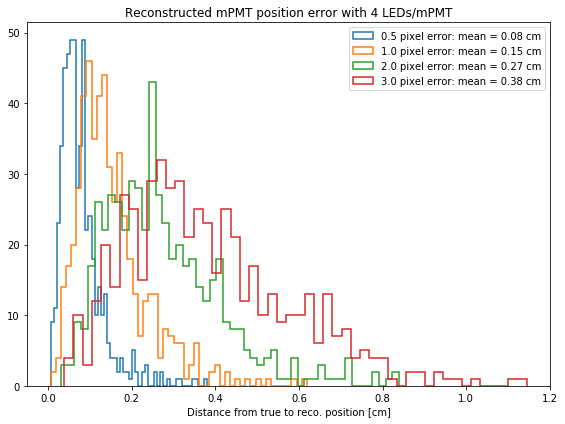

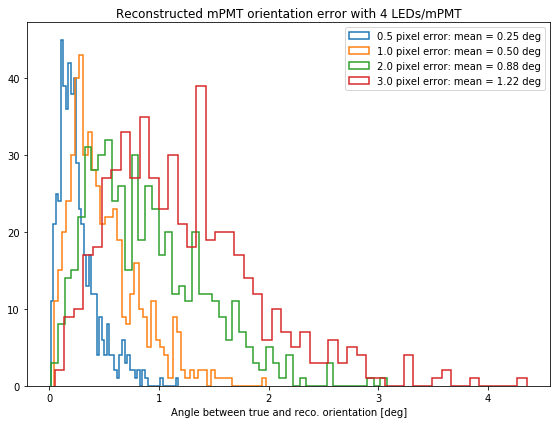

In [18]:
led_count = 4
led_positions = get_led_positions(led_count, mpmt_locations)
#ring_positions = get_ring_positions(bolt_positions, pmt_locations.keys(), bolt_count)
#ring_orientations = get_ring_orientations(bolt_positions, pmt_locations.keys(), bolt_count)
simulator = fit.PhotogrammetrySimulator(led_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)
image_feature_locations = simulator.get_image_feature_locations(area_restrict = [[0, 4000], [0, 3000]], min_feature_count = 2)
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
print("Feature in image counts:", Counter(feature_counts.values()))
simulator.show_images(image_feature_locations, area=[[0,4000],[0,3000]])


fig_led_pos, ax_led_pos = make_fig("Reconstructed LED position error with {} LEDs/mPMT".format(led_count), "Distance from true to reco. position [cm]")
fig_mpmt_pos, ax_mpmt_pos = make_fig("Reconstructed mPMT position error with {} LEDs/mPMT".format(led_count), "Distance from true to reco. position [cm]")
fig_mpmt_ang, ax_mpmt_ang = make_fig("Reconstructed mPMT orientation error with {} LEDs/mPMT".format(led_count), "Angle between true and reco. orientation [deg]")
for pixel_error in [0.5, 1.0, 2.0, 3.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=[[0, 4000], [0, 3000]], min_feature_count=2, pixel_error=pixel_error)
    led_positions2 = {k: v for k, v in led_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_led_simulation(led_positions2, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_led_positions, position_errors = run_led_fit(fitter, led_positions)
    centre_errors = get_mpmt_centre_errors(reco_led_positions, mpmt_locations, led_count)
    orientation_errors = get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_count)
    ax_led_pos.hist(position_errors, bins=50, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors.mean()))
    ax_mpmt_pos.hist(centre_errors, bins=50, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors.mean()))
    ax_mpmt_ang.hist(orientation_errors, bins=50, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors.mean()))
ax_led_pos.legend(loc='upper right')
ax_mpmt_pos.legend(loc='upper right')
ax_mpmt_ang.legend(loc='upper right')

# Simulation with 6 LEDs

Feature in image counts: Counter({4: 1792, 3: 1224, 5: 200})
=== Gaussian errors on feature image locations: 0.5 ===
6 images with total of  3216 features
image 0 reprojection errors:    average: 4.216580522173593    max: 30.596937013626473
image 1 reprojection errors:    average: 4.403206083754362    max: 70.92991107059544
image 2 reprojection errors:    average: 4.251469807369922    max: 36.182163443430845
image 3 reprojection errors:    average: 4.2397210622151436    max: 37.34832975959539
image 4 reprojection errors:    average: 4.4130638015067225    max: 31.917749212623633
image 5 reprojection errors:    average: 4.545520083383028    max: 23.23174602159739
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7460e+05                                    3.63e+05    
       1              2         1.4144e+03      1.73e+05       9.51e+01       1.11e+04    
       2              3         1.1182e+03      2.96e+02 

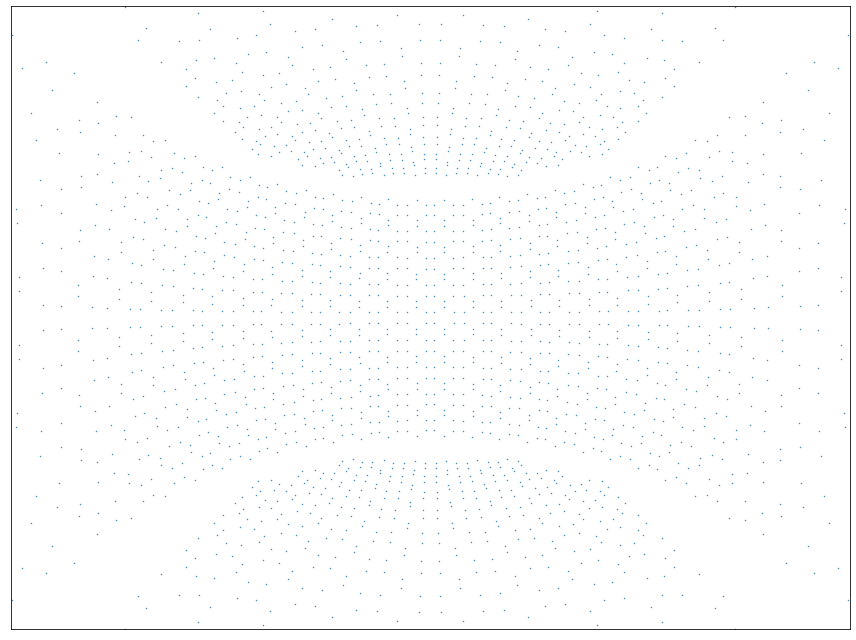

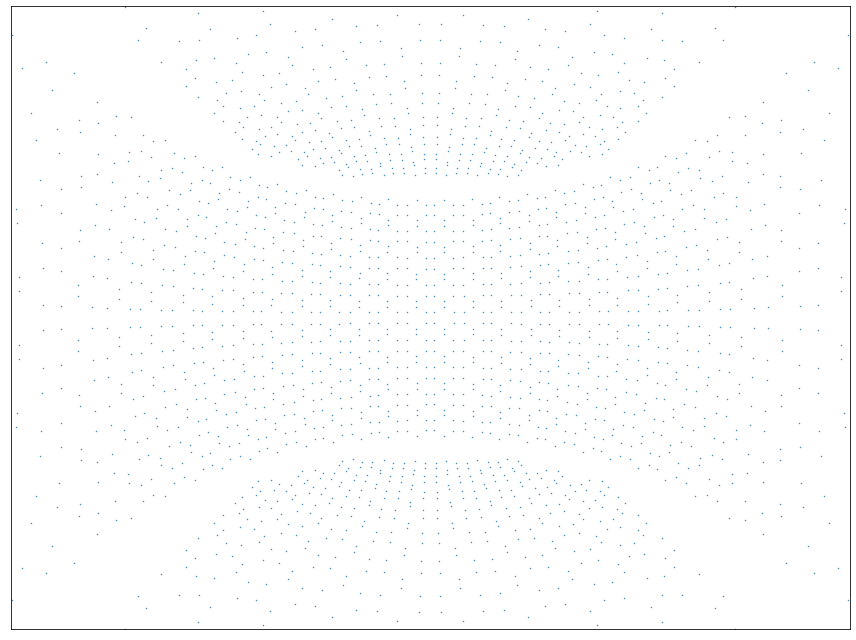

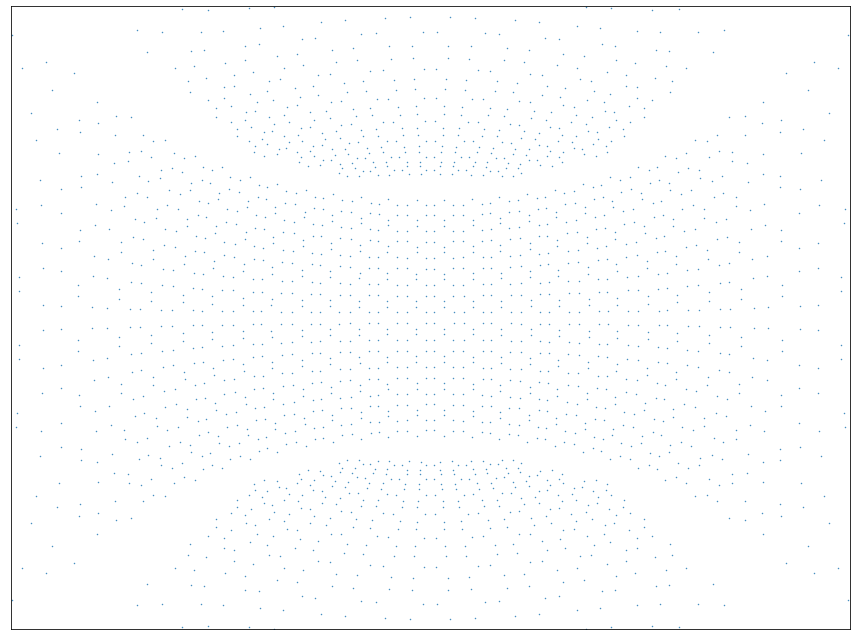

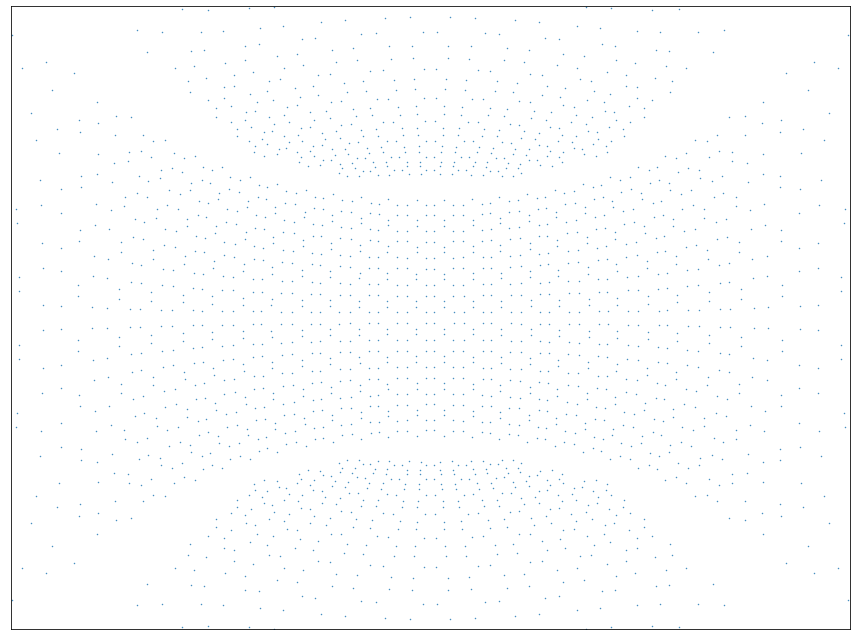

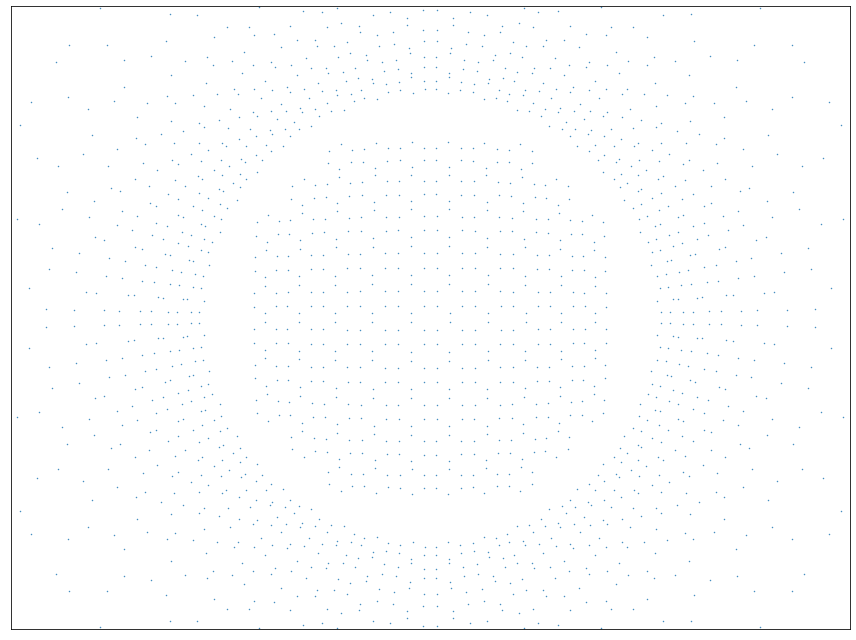

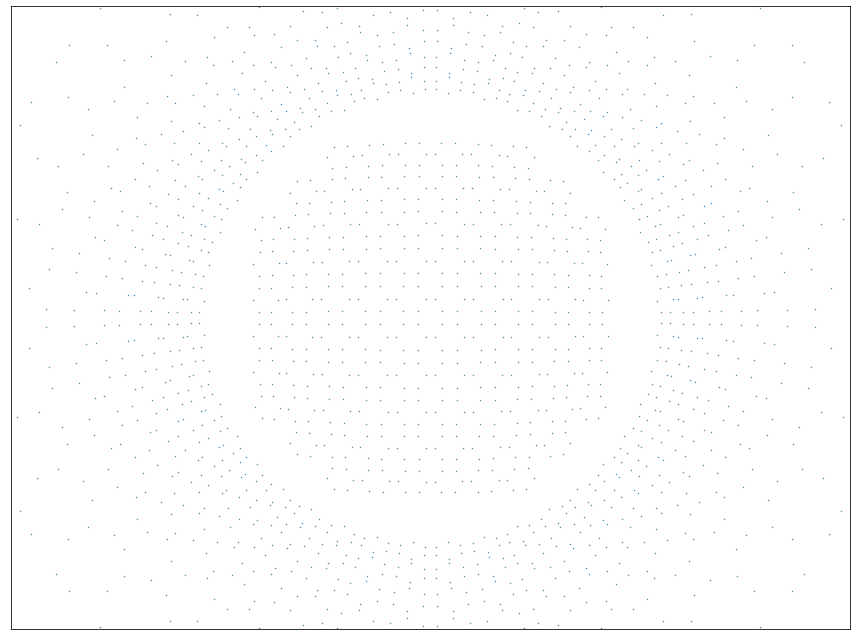

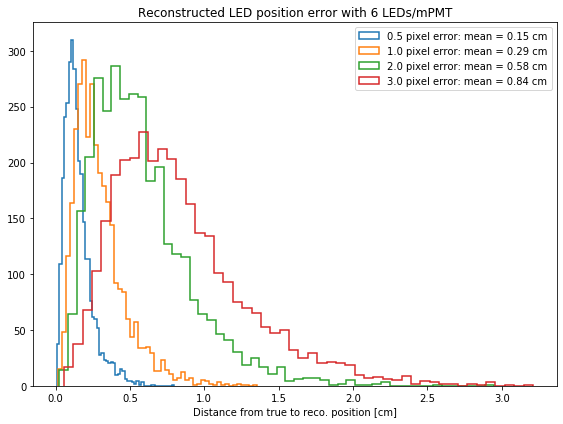

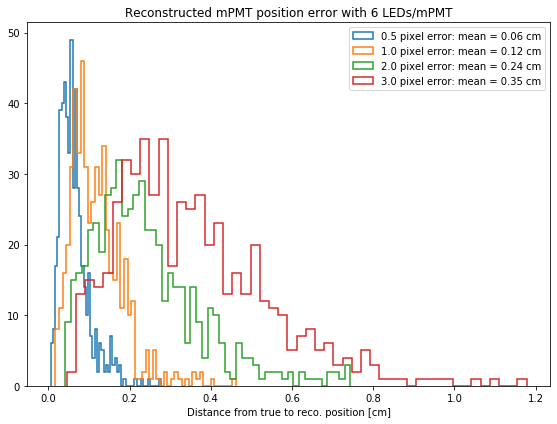

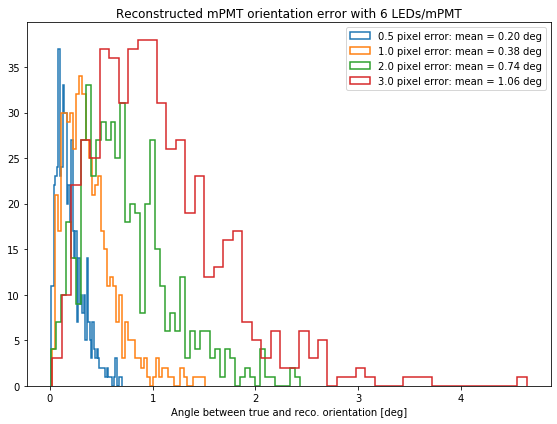

In [19]:
led_count = 6
led_positions = get_led_positions(led_count, mpmt_locations)
#ring_positions = get_ring_positions(bolt_positions, pmt_locations.keys(), bolt_count)
#ring_orientations = get_ring_orientations(bolt_positions, pmt_locations.keys(), bolt_count)
simulator = fit.PhotogrammetrySimulator(led_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)
image_feature_locations = simulator.get_image_feature_locations(area_restrict = [[0, 4000], [0, 3000]], min_feature_count = 2)
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
print("Feature in image counts:", Counter(feature_counts.values()))
simulator.show_images(image_feature_locations, area=[[0,4000],[0,3000]])


fig_led_pos, ax_led_pos = make_fig("Reconstructed LED position error with {} LEDs/mPMT".format(led_count), "Distance from true to reco. position [cm]")
fig_mpmt_pos, ax_mpmt_pos = make_fig("Reconstructed mPMT position error with {} LEDs/mPMT".format(led_count), "Distance from true to reco. position [cm]")
fig_mpmt_ang, ax_mpmt_ang = make_fig("Reconstructed mPMT orientation error with {} LEDs/mPMT".format(led_count), "Angle between true and reco. orientation [deg]")
for pixel_error in [0.5, 1.0, 2.0, 3.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=[[0, 4000], [0, 3000]], min_feature_count=2, pixel_error=pixel_error)
    led_positions2 = {k: v for k, v in led_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_led_simulation(led_positions2, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_led_positions, position_errors = run_led_fit(fitter, led_positions)
    centre_errors = get_mpmt_centre_errors(reco_led_positions, mpmt_locations, led_count)
    orientation_errors = get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_count)
    ax_led_pos.hist(position_errors, bins=50, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors.mean()))
    ax_mpmt_pos.hist(centre_errors, bins=50, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors.mean()))
    ax_mpmt_ang.hist(orientation_errors, bins=50, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors.mean()))
ax_led_pos.legend(loc='upper right')
ax_mpmt_pos.legend(loc='upper right')
ax_mpmt_ang.legend(loc='upper right')

# Simulation with 12 LEDs

Feature in image counts: Counter({4: 3544, 3: 2480, 5: 408})
=== Gaussian errors on feature image locations: 0.5 ===
6 images with total of  6432 features
image 0 reprojection errors:    average: 4.279986200665072    max: 91.64168801679001
image 1 reprojection errors:    average: 4.325447838364877    max: 247.8971789633436
image 2 reprojection errors:    average: 4.274899446402483    max: 275.5103628981071
image 3 reprojection errors:    average: 4.40010927439838    max: 253.55675186939868
image 4 reprojection errors:    average: 4.578380030791675    max: 34.49396318084797
image 5 reprojection errors:    average: 4.487576514768437    max: 47.74676589314113
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.8826e+05                                    1.85e+07    
       1              2         1.4272e+04      4.74e+05       1.21e+02       4.61e+06    
       2              3         3.4546e+03      1.08e+04      

      17             18         3.7808e+04      1.13e+01       1.30e-01       1.58e+03    
      18             19         3.7797e+04      1.11e+01       5.46e-02       1.58e+02    
      19             20         3.7785e+04      1.19e+01       1.39e-01       1.60e+03    
      20             21         3.7773e+04      1.17e+01       5.51e-02       1.54e+02    
      21             22         3.7761e+04      1.21e+01       1.44e-01       1.60e+03    
      22             23         3.7749e+04      1.18e+01       5.44e-02       1.50e+02    
      23             24         3.7737e+04      1.24e+01       1.50e-01       1.63e+03    
      24             25         3.7725e+04      1.21e+01       5.36e-02       1.45e+02    
      25             26         3.7712e+04      1.24e+01       1.54e-01       1.66e+03    
      26             27         3.7700e+04      1.21e+01       5.20e-02       1.37e+02    
      27             28         3.7687e+04      1.27e+01       1.60e-01       1.70e+03    

      51             52         8.3659e+04      1.25e+01       1.22e-01       8.77e+02    
      52             53         8.3646e+04      1.24e+01       4.20e-02       1.19e+02    
      53             54         8.3636e+04      1.05e+01       1.02e-01       7.14e+02    
      54             55         8.3625e+04      1.06e+01       3.97e-02       1.37e+02    
      55             56         8.3616e+04      9.60e+00       9.22e-02       6.16e+02    
      56             57         8.3606e+04      9.72e+00       3.83e-02       1.54e+02    
      57             58         8.3597e+04      9.35e+00       8.93e-02       5.71e+02    
      58             59         8.3587e+04      9.48e+00       3.82e-02       1.71e+02    
      59             60         8.3578e+04      8.71e+00       8.23e-02       5.13e+02    
      60             61         8.3570e+04      8.75e+00       3.67e-02       1.84e+02    
      61             62         8.3561e+04      8.82e+00       8.32e-02       5.15e+02    

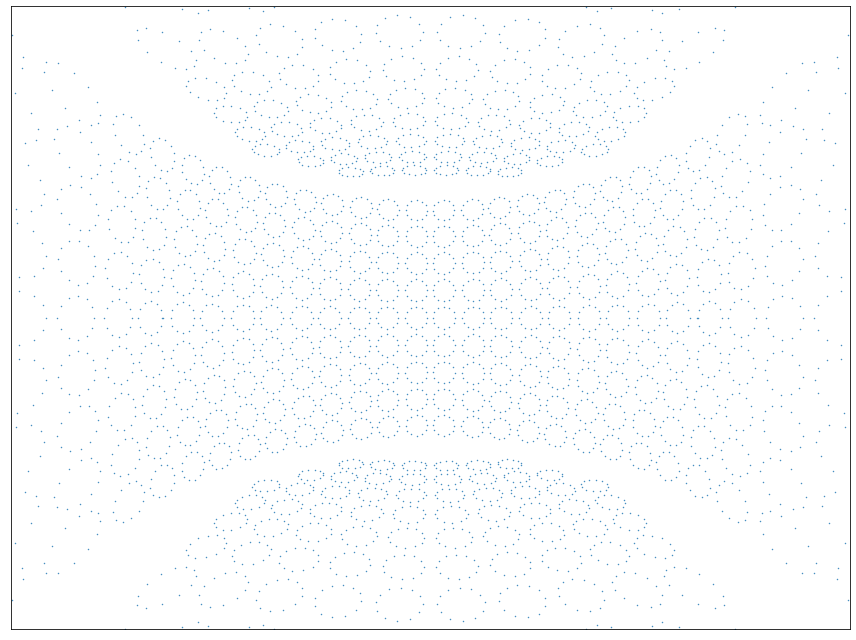

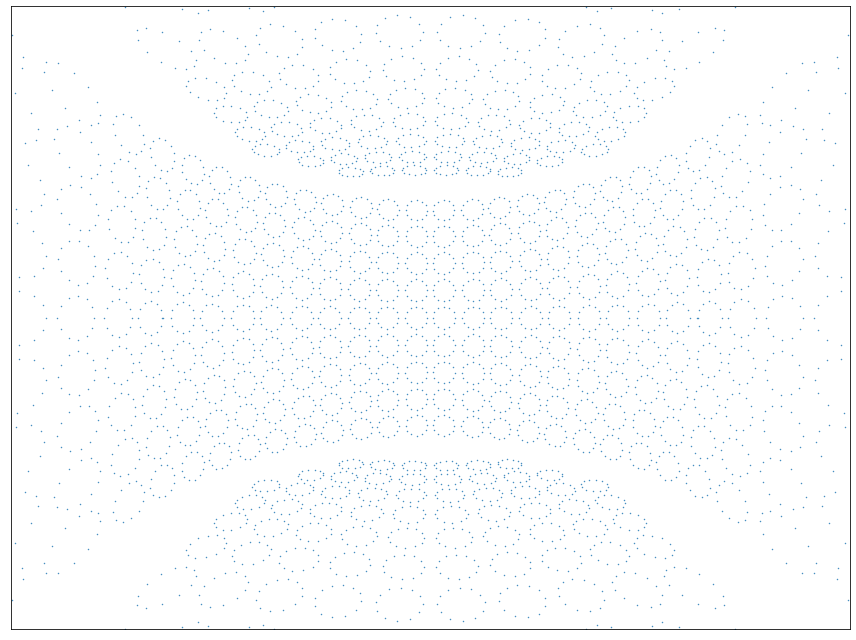

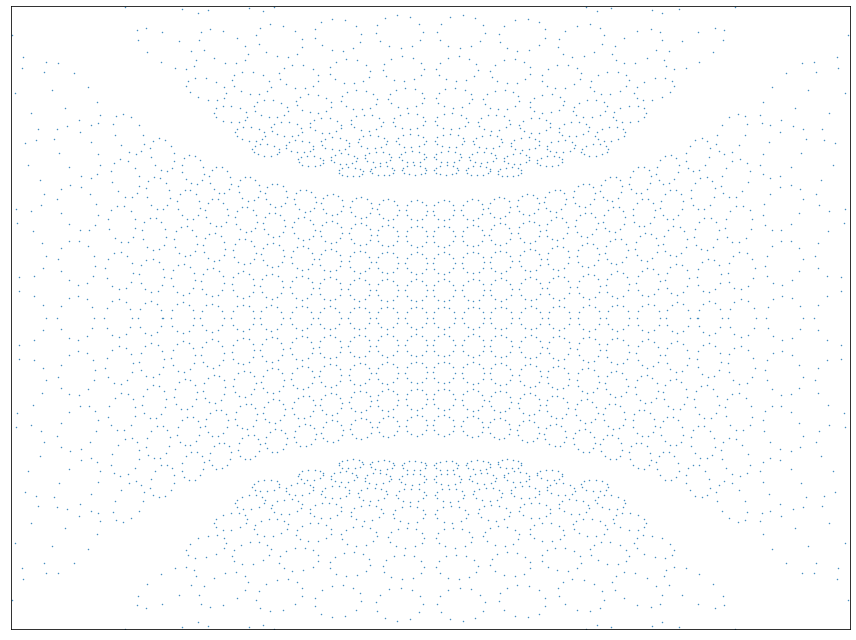

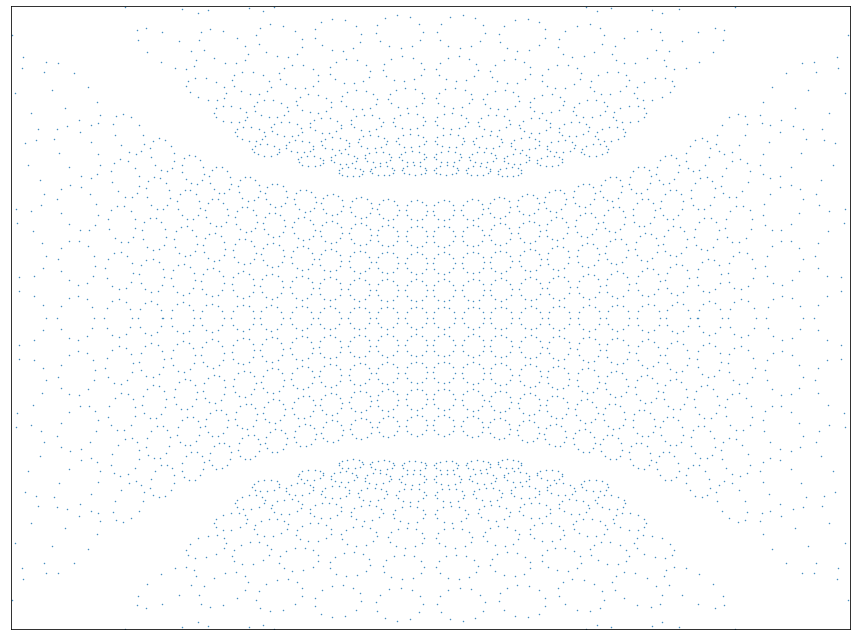

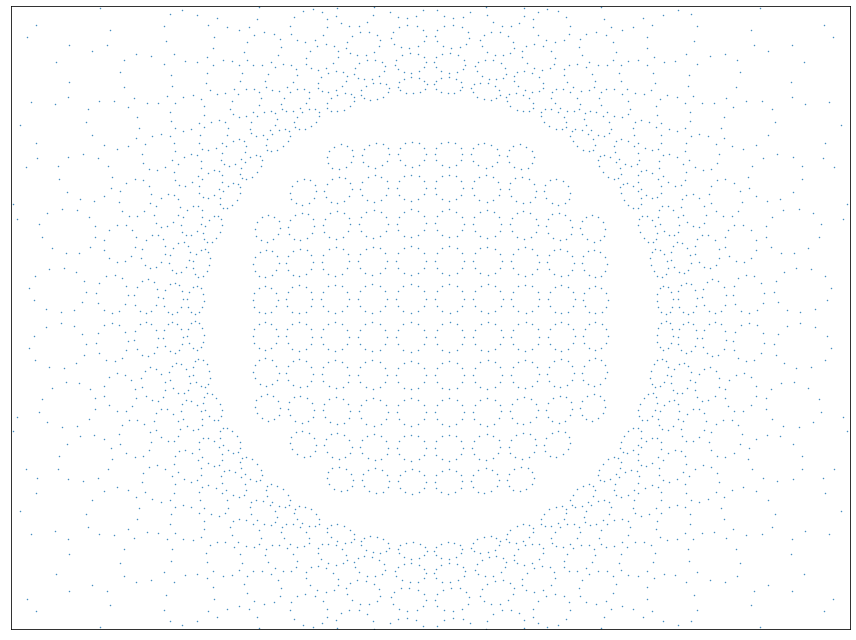

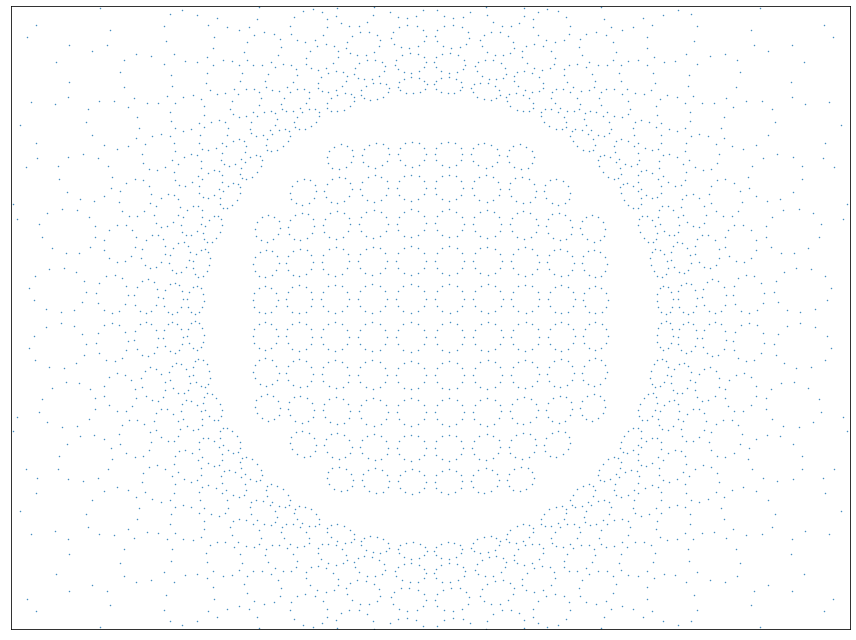

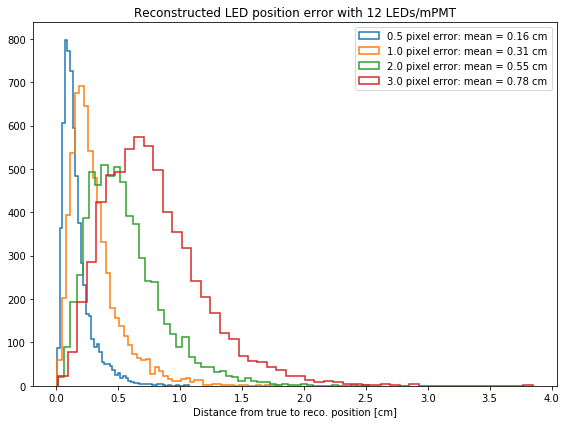

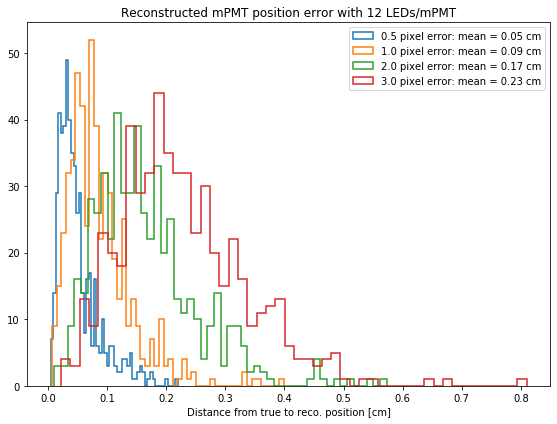

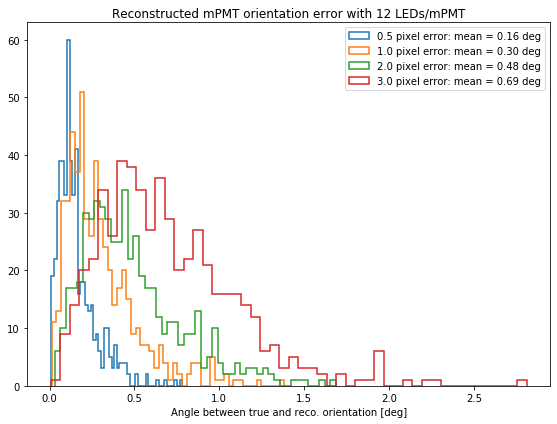

In [20]:
led_count = 12
led_positions = get_led_positions(led_count, mpmt_locations)
#ring_positions = get_ring_positions(bolt_positions, pmt_locations.keys(), bolt_count)
#ring_orientations = get_ring_orientations(bolt_positions, pmt_locations.keys(), bolt_count)
simulator = fit.PhotogrammetrySimulator(led_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)
image_feature_locations = simulator.get_image_feature_locations(area_restrict = [[0, 4000], [0, 3000]], min_feature_count = 2)
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
print("Feature in image counts:", Counter(feature_counts.values()))
simulator.show_images(image_feature_locations, area=[[0,4000],[0,3000]])


fig_led_pos, ax_led_pos = make_fig("Reconstructed LED position error with {} LEDs/mPMT".format(led_count), "Distance from true to reco. position [cm]")
fig_mpmt_pos, ax_mpmt_pos = make_fig("Reconstructed mPMT position error with {} LEDs/mPMT".format(led_count), "Distance from true to reco. position [cm]")
fig_mpmt_ang, ax_mpmt_ang = make_fig("Reconstructed mPMT orientation error with {} LEDs/mPMT".format(led_count), "Angle between true and reco. orientation [deg]")
for pixel_error in [0.5, 1.0, 2.0, 3.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=[[0, 4000], [0, 3000]], min_feature_count=2, pixel_error=pixel_error)
    led_positions2 = {k: v for k, v in led_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_led_simulation(led_positions2, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_led_positions, position_errors = run_led_fit(fitter, led_positions)
    centre_errors = get_mpmt_centre_errors(reco_led_positions, mpmt_locations, led_count)
    orientation_errors = get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_count)
    ax_led_pos.hist(position_errors, bins=50, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors.mean()))
    ax_mpmt_pos.hist(centre_errors, bins=50, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors.mean()))
    ax_mpmt_ang.hist(orientation_errors, bins=50, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors.mean()))
ax_led_pos.legend(loc='upper right')
ax_mpmt_pos.legend(loc='upper right')
ax_mpmt_ang.legend(loc='upper right')

In [21]:
def plot_reconstruction(reco_positions, cam_positions):
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(reco_positions[:,0], reco_positions[:,2], reco_positions[:,1], marker='^', label="LED", s=1)
    ax.scatter(cam_positions[:,0], cam_positions[:,2], cam_positions[:,1], marker='*', label="Camera", s=60)
    plt.legend(loc=0)
    fig.tight_layout()

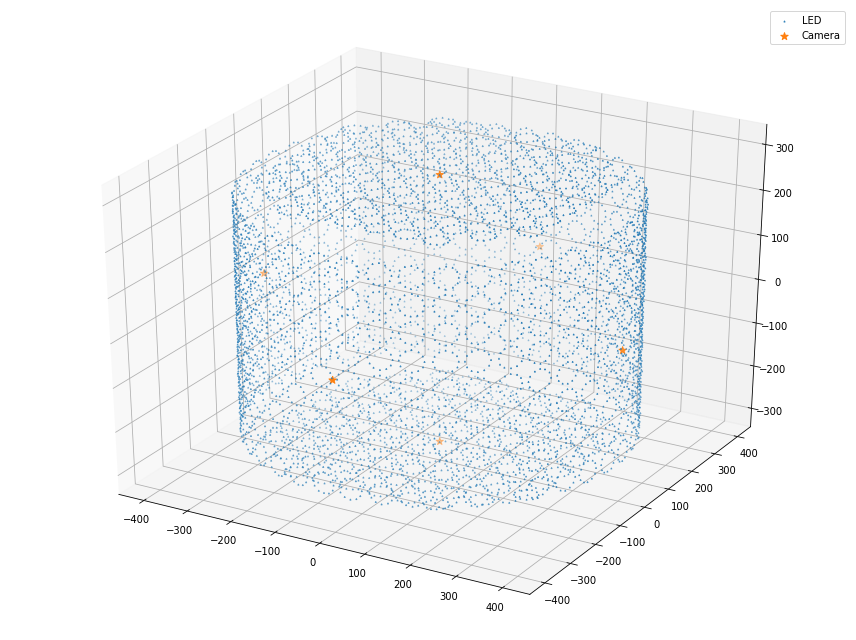

In [22]:
reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(led_positions, reco_led_positions)

reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
cam_positions_translated = reco_cam_positions - translation
cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

plot_reconstruction(reco_transformed, cam_positions_transformed)